In [ ]:
print('Connect to google drive')
from google.colab import drive
drive.mount('/gdrive')

Connect to google drive
Mounted at /gdrive


In [ ]:
print('Import necessary libraries')

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import glob
import pickle

import warnings
warnings.filterwarnings("ignore")

import random
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import gc
import tqdm

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt

Import necessary libraries


In [ ]:
base_path='/gdrive/My Drive/Colab Notebooks/'
weights_path='/gdrive/My Drive/Colab Notebooks/weights/'

In [ ]:
def euclidean_distance(x_true,y_true, x_pred, y_pred):
    return np.mean(((x_true-x_pred)**2+(y_true-y_pred)**2)**0.5)    

In [ ]:
version='forPdata423_BSSIDSresilience'


In [ ]:
data=pd.read_csv('/gdrive/My Drive/Colab Notebooks/data423.csv.zip') #
data.shape

(14373, 316)

In [ ]:
rssidsnums=[int(x[4:]) for x in data.columns if 'rsid' in x]
print(len(rssidsnums))

312


In [ ]:
data.head()

,rsid1,rsid2,rsid3,rsid4,rsid5,rsid6,rsid7,rsid8,rsid9,rsid10,...,rsid307,rsid308,rsid309,rsid310,rsid311,rsid312,x,y,timestamp,path
0,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934464983,record_2021_10_11_07_41_02
1,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934467125,record_2021_10_11_07_41_02
2,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934469251,record_2021_10_11_07_41_02
3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934471370,record_2021_10_11_07_41_02
4,-78,-999,-999,-95,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,40.85,25.74,1633934473508,record_2021_10_11_07_41_02


In [ ]:
TRAIN_FEATS=[x for x in data.columns if x not in ['x', 'y', 'path', 'timestamp']]
len(TRAIN_FEATS)

312

In [ ]:
unpaths=data.path.unique()

In [ ]:
print('we have ',len(unpaths),' unique paths')

we have  423  unique paths


### CV TRAIN

In [ ]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.2,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 11,
    "num_leaves": 256,  
    "max_bin": 256,
    "num_iterations": 15000
}
# hyper_params = {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': ['l1','l2'],
#     'learning_rate': 0.005,
#     'feature_fraction': 0.2,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 10,
#     'verbose': 0,
#     "max_depth": 14,
#     "num_leaves": 256,  
#     "max_bin": 256,
#     "num_iterations": 15000
# }


In [ ]:
# weights_path

In [ ]:
lgbm_modelsX=[]
lgbm_modelsY=[]
for f in range(5):
    lgbm_modelsX.append(joblib.load( weights_path+'fold_'+str(f)+'x'+'_v2'))
    lgbm_modelsY.append(joblib.load( weights_path+'fold_'+str(f)+'y'+'_v2'))

In [ ]:
# CROSS VALIDATION

name='lgbm'+version


scores=[]
for rs in range(1,312):
    # np.random.seed(2022+rs)
    # selected_rsidnums=np.sort(np.random.choice(np.arange(min(rssidsnums),max(rssidsnums)), size=234,replace=False))
    # selected_rsids=['rsid'+str(x) for x in selected_rsidnums]
    # TRAIN_FEATS=selected_rsids[:]
    # # print(len(selected_rsids))

    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)


    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)
        
        # X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

        # y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val.iloc[:,-rs:]=-999

        val_predsXY=[]
        for i in range(2):
            # y_train = y_trainXY[:,i]
            y_val = y_valXY[:,i]

            # gbm = lgb.LGBMRegressor(**hyper_params)
            if i==0:
                model=lgbm_modelsX[f]
            else:
                model=lgbm_modelsY[f]
            
            
            val_predsXY.append(model.predict(X_val, num_iteration=model.best_iteration_) )
        val_predsXY=np.stack(val_predsXY).T
        
        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_valXY)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    # print(np.mean(scores))
    # print('---------------------')

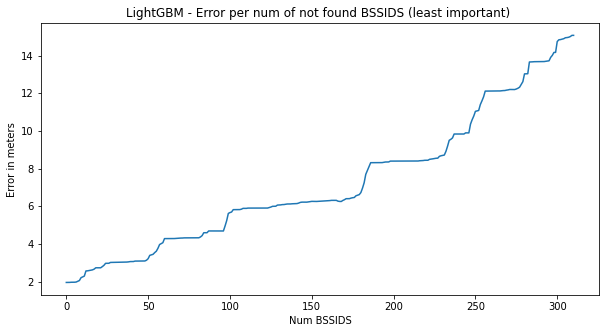

In [ ]:

plt.figure(figsize=(10,5))
plt.plot(scores)
plt.title('LightGBM - Error per num of not found BSSIDS (least important) ')
plt.xlabel('Num BSSIDS')
plt.ylabel('Error in meters')
plt.show()


In [ ]:
pd.DataFrame({'num_bssids':np.arange(1,312),
              'scores':np.array(scores)}).to_csv('/gdrive/My Drive/Colab Notebooks/LightGBM_'+version+'_LeastImportant.csv',index=False)

In [ ]:
scores1=scores[:]

In [ ]:
# CROSS VALIDATION

name='lgbm'+version


scores=[]
for rs in range(1,312):
    # np.random.seed(2022+rs)
    # selected_rsidnums=np.sort(np.random.choice(np.arange(min(rssidsnums),max(rssidsnums)), size=234,replace=False))
    # selected_rsids=['rsid'+str(x) for x in selected_rsidnums]
    # TRAIN_FEATS=selected_rsids[:]
    # # print(len(selected_rsids))

    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)


    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)
        
        # X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

        # y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val.iloc[:,np.random.choice(np.arange(312),size=rs, replace=False)]=-999

        val_predsXY=[]
        for i in range(2):
            # y_train = y_trainXY[:,i]
            y_val = y_valXY[:,i]

            # gbm = lgb.LGBMRegressor(**hyper_params)
            if i==0:
                model=lgbm_modelsX[f]
            else:
                model=lgbm_modelsY[f]
            
            
            val_predsXY.append(model.predict(X_val, num_iteration=model.best_iteration_) )
        val_predsXY=np.stack(val_predsXY).T
        
        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_valXY)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    # print(np.mean(scores))
    # print('---------------------')

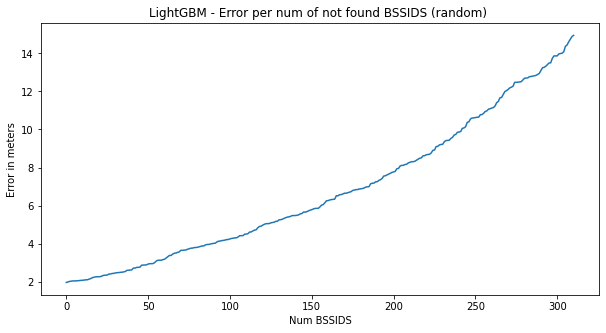

In [ ]:

plt.figure(figsize=(10,5))
plt.plot(scores)
plt.title('LightGBM - Error per num of not found BSSIDS (random) ')
plt.xlabel('Num BSSIDS')
plt.ylabel('Error in meters')
plt.show()


In [ ]:
pd.DataFrame({'num_bssids':np.arange(1,312),
              'scores':np.array(scores)}).to_csv('/gdrive/My Drive/Colab Notebooks/LightGBM_'+version+'_random.csv',index=False)

In [ ]:
scores2=scores[:]

In [ ]:
# CROSS VALIDATION

name='lgbm'+version
REPEATS=3

scores=[]
for rs in range(1,312):
    # np.random.seed(2022+rs)
    # selected_rsidnums=np.sort(np.random.choice(np.arange(min(rssidsnums),max(rssidsnums)), size=234,replace=False))
    # selected_rsids=['rsid'+str(x) for x in selected_rsidnums]
    # TRAIN_FEATS=selected_rsids[:]
    # # print(len(selected_rsids))

    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]



    np.random.seed(42)
    sh=np.random.permutation(unpaths)

    all_predsRs=[]
    for r in range(REPEATS):
        all_preds=[]
        all_targets=[]
        k=5
        val_size=int(len(sh)/k)
        for f in range(k):
            # print('fold:', f)

            if f<(k-1):
                val_paths=sh[val_size*f:val_size*(f+1)]
            else:
                val_paths=sh[val_size*f:]

            train_paths=[x for x in unpaths if x not in val_paths]
            
            val_paths=np.array(val_paths)
            train_paths=np.array(train_paths)
            
            # X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

            # y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

            X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
            y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values

            X_val.iloc[:,np.random.choice(np.arange(312),size=rs, replace=False)]=-999

            val_predsXY=[]
            for i in range(2):
                # y_train = y_trainXY[:,i]
                y_val = y_valXY[:,i]

                # gbm = lgb.LGBMRegressor(**hyper_params)
                if i==0:
                    model=lgbm_modelsX[f]
                else:
                    model=lgbm_modelsY[f]
                
                
                val_predsXY.append(model.predict(X_val, num_iteration=model.best_iteration_) )
            val_predsXY=np.stack(val_predsXY).T
            
            # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

            all_preds.append(val_predsXY)
            all_targets.append(y_valXY)
            
        all_predsRs.append(np.vstack(all_preds))
    all_preds= np.mean(np.stack(all_predsRs),0)

    all_predsV=all_preds
    # all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    # print(np.mean(scores))
    # print('---------------------')

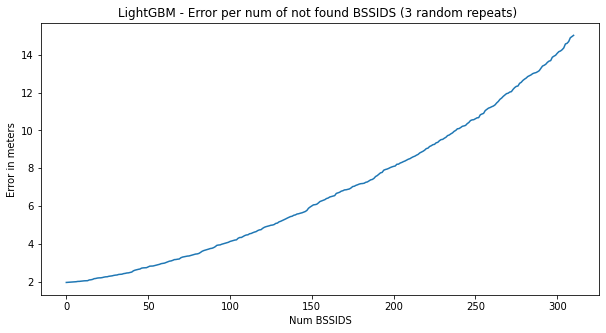

In [ ]:

plt.figure(figsize=(10,5))
plt.plot(scores)
plt.title('LightGBM - Error per num of not found BSSIDS (3 random repeats) ')
plt.xlabel('Num BSSIDS')
plt.ylabel('Error in meters')
plt.show()


In [ ]:
pd.DataFrame({'num_bssids':np.arange(1,312),
              'scores':np.array(scores)}).to_csv('/gdrive/My Drive/Colab Notebooks/LightGBM_'+version+'_random3R.csv',index=False)

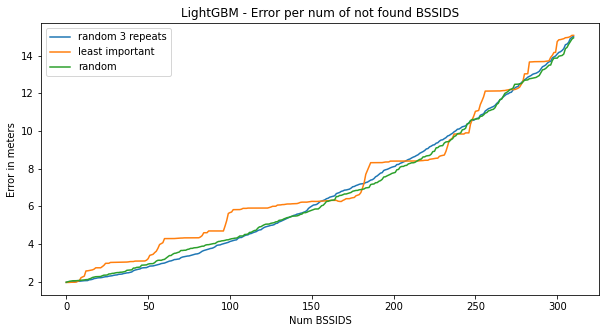

In [ ]:

plt.figure(figsize=(10,5))
plt.plot(scores, label='random 3 repeats')
plt.plot(scores1, label='least important')
plt.plot(scores2, label='random')
plt.legend()
plt.title('LightGBM - Error per num of not found BSSIDS')
plt.xlabel('Num BSSIDS')
plt.ylabel('Error in meters')
plt.show()


In [ ]:
version

'forPdata423_BSSIDSresilience'

In [ ]:
lgbmS=pd.read_csv('/gdrive/My Drive/Colab Notebooks/LightGBM_'+version+'_random.csv')
kerasS=pd.read_csv('/gdrive/My Drive/Colab Notebooks/Keras_'+version+'_random.csv')
# kneighborsS=pd.read_csv('/gdrive/My Drive/Colab Notebooks/KNeighbors_'+version+'_random3R.csv')
kneighborsS=pd.read_csv('/gdrive/My Drive/Colab Notebooks/KNeighbors_'+version+'_random.csv')

EnsKerasLgbm=pd.read_csv('/gdrive/My Drive/Colab Notebooks/EnsKeras2Lgbm_'+version+'_random.csv')

In [ ]:
kneighborsS.scores.ewm(alpha=0.1)

ExponentialMovingWindow [alpha=0.1,min_periods=1,adjust=True,ignore_na=False,axis=0]

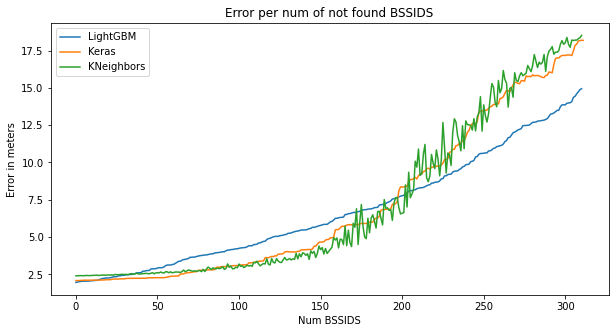

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(lgbmS.scores.values, label='LightGBM')
plt.plot(kerasS.iloc[:,1:].scores.values, label='Keras')
plt.plot(kneighborsS.scores, label='KNeighbors')
plt.legend()
plt.title('Error per num of not found BSSIDS')
plt.xlabel('Num BSSIDS')
plt.ylabel('Error in meters')
plt.show()

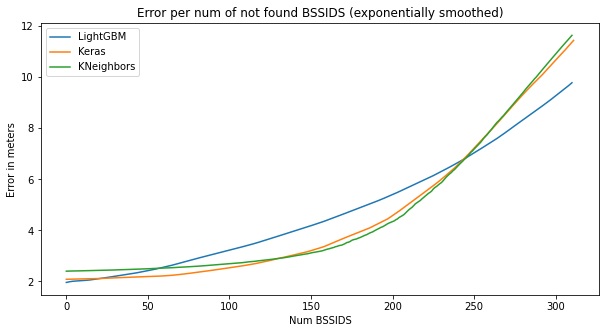

In [ ]:
ALPHA=0.01

plt.figure(figsize=(10,5))
plt.plot(lgbmS.scores.ewm(alpha=ALPHA).mean().values, label='LightGBM')
plt.plot(kerasS.iloc[:,1:].scores.ewm(alpha=ALPHA).mean().values, label='Keras')
plt.plot(kneighborsS.scores.ewm(alpha=ALPHA).mean(), label='KNeighbors')
plt.legend()
plt.title('Error per num of not found BSSIDS (exponentially smoothed)')
plt.xlabel('Num BSSIDS')
plt.ylabel('Error in meters')
plt.show()

In [ ]:
kerasS

,num_bssids,scores
0,0,2.086317
1,1,2.086241
2,2,2.086300
3,3,2.100331
4,4,2.099273
...,...,...
307,307,17.936666
308,308,18.136301
309,309,18.172022
310,310,18.189194


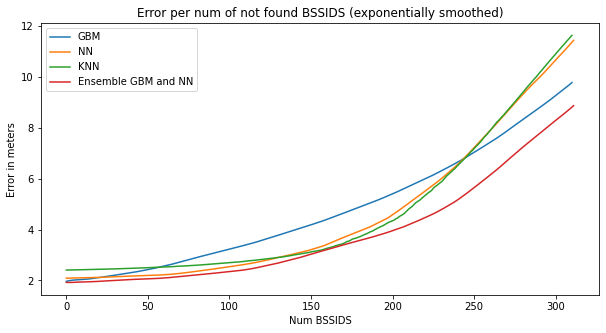

In [ ]:
ALPHA=0.01

plt.figure(figsize=(10,5))
plt.plot(lgbmS.scores.ewm(alpha=ALPHA).mean().values, label='GBM')
plt.plot(kerasS.iloc[:,1:].scores.ewm(alpha=ALPHA).mean().values, label='NN')
plt.plot(kneighborsS.scores.ewm(alpha=ALPHA).mean(), label='KNN')
# plt.plot(((2*lgbmS.scores+kerasS.scores)/3).ewm(alpha=ALPHA).mean(), label='Ensemble GBM and NN')
plt.plot(EnsKerasLgbm.scores.ewm(alpha=ALPHA).mean(), label='Ensemble GBM and NN')
plt.legend()
plt.title('Error per num of not found BSSIDS (exponentially smoothed)')
plt.xlabel('Num BSSIDS')
plt.ylabel('Error in meters')
plt.show()

In [ ]:
lgbmS.scores.ewm(alpha=ALPHA).mean().values[[np.arange(20,300,50)]],kerasS.iloc[:,1:].scores.ewm(alpha=ALPHA).mean().values[[np.arange(20,300,50)]],kneighborsS.scores.ewm(alpha=ALPHA).mean().values[[np.arange(20,300,50)]]

(array([2.11101354, 2.72743369, 3.57732547, 4.64418175, 5.99254376,
        7.86823635]),
 array([2.11514298, 2.27694223, 2.75404028, 3.68916766, 5.51557022,
        8.6157694 ]),
 array([2.4338857 , 2.56045639, 2.82434383, 3.45725419, 5.33376409,
        8.64858528]))

In [ ]:
import seaborn as sns
def plotImp(feature_imp, num = 20, fig_size = (10, 5)):
    # feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

In [ ]:
Ximp=((lgbm_modelsX[0].feature_importances_+lgbm_modelsX[1].feature_importances_+lgbm_modelsX[2].feature_importances_+lgbm_modelsX[3].feature_importances_+lgbm_modelsX[4].feature_importances_)/5).astype(int)
Yimp=((lgbm_modelsY[0].feature_importances_+lgbm_modelsY[1].feature_importances_+lgbm_modelsY[2].feature_importances_+lgbm_modelsY[3].feature_importances_+lgbm_modelsY[4].feature_importances_)/5).astype(int)

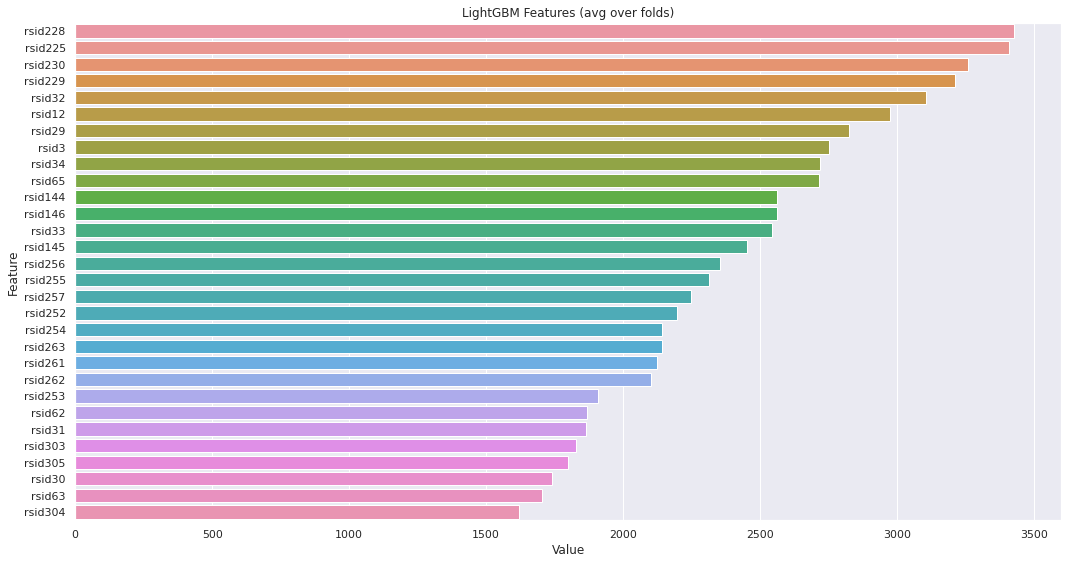

In [ ]:
plotImp(pd.DataFrame({'Value':Ximp+Yimp,'Feature':TRAIN_FEATS}), num = 30, fig_size = (15, 8))

In [ ]:
# lgbm_modelsX[0].feature_importances_
np.corrcoef(Ximp,Yimp)

array([[1.        , 0.93405816],
       [0.93405816, 1.        ]])

In [ ]:
np.corrcoef(lgbm_modelsX[0].feature_importances_,lgbm_modelsX[1].feature_importances_)

array([[1.        , 0.97389275],
       [0.97389275, 1.        ]])

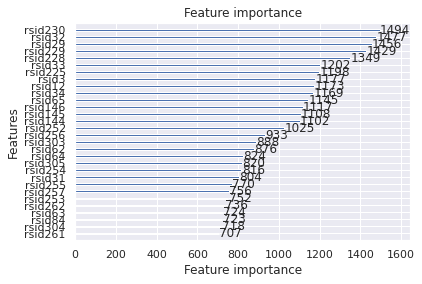

In [ ]:
lgb.plot_importance(lgbm_modelsX[0],max_num_features=30)

In [ ]:
.

In [ ]:
# pd.DataFrame(all_predsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/'+name+'_oof2.csv.gz', index=False, compression='gzip')
# pd.DataFrame(all_targetsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/all_targetsV2.csv.gz', index=False, compression='gzip')

In [ ]:
# '/gdrive/My Drive/Colab Notebooks/'+name+'_oof.csv.gz'

In [ ]:

version

'forPdata423_BSSIDSresilience'

## Full train

In [ ]:
# hyper_params["num_iterations"]= 2500

In [ ]:


# name=version+'lgbm'

# train_paths=unpaths[:]

# train_paths=np.array(train_paths)

# X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

# y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

# train_predsXY=[]
# all_train_targets=[]
# xy=['x', 'y']
# for i in range(2):
#     y_train = y_trainXY[:,i]

#     gbm = lgb.LGBMRegressor(**hyper_params)


#     model = gbm.fit(X_train, y_train,
#         eval_set=[(X_train, y_train)],
#         eval_metric='l1',
#         verbose=100
#         )
    
#     # joblib.dump(model, weights_path+'FullTrain_'+['x','y'][i])
#     joblib.dump(model,'/gdrive/My Drive/Colab Notebooks/weights/'+name+'_model'+xy[i])

#     train_predsXY.append(gbm.predict(X_train, num_iteration=gbm.best_iteration_) )

# train_predsXY=np.stack(train_predsXY).T

# print('train error',euclidean_distance(train_predsXY[:,0], train_predsXY[:,1], y_trainXY[:,0], y_trainXY[:,1]))


In [ ]:
# print('Save LightGBM model fully trained')
# joblib.dump(model,'/gdrive/My Drive/Colab Notebooks/weights/'+name+'_model')